In [20]:
import xarray as xr
import matplotlib.pyplot as plt
import time
import numpy as np
import xarray as xr
import time
import numpy as np
import cartopy.crs as ccrs
import cartopy as cart
import xclim as xc
import os
from memory_profiler import profile

from matplotlib.colors import BoundaryNorm
import matplotlib.ticker as mticker
import matplotlib.colors as mplcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean as cmo

import matplotlib.gridspec as gridspec
# own functions
import Plot.plotfunctions as plotfunc
import Calculation.humiditycalculation as humidcalc
import Calculation.trend_func as trends
import Calculation.save_detrend_deseason as sdd
import Calculation.heat_wave_indetification as hwi
import Calculation.mask_creation as mc
homefolder = '/home/nniebaum/data_nils'
datafolder = '/data/user/nniebaum'
plotfolder = '/home/nniebaum/bachlor-thesis-code/Plots/'
areafolder = plotfolder + "Area/"


plt.rcParams.update(plotfunc.rcParams_area)

projection = ccrs.EckertV(central_longitude=12.5)

**Open daily max dataset**

In [22]:
data= xr.open_dataset(datafolder + '/New_europe_full_daymax_masks_population_1900-01-01_2010-12-31.nc')


duration = data.heatwave_mask_ydrunpctl_95.attrs['duration']
threshold = data.heatwave_mask_ydrunpctl_95.attrs['threshold']
quantile = data.heatwave_mask_ydrunpctl_95.attrs['quantile']

**Examples of strong heat waves**

/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


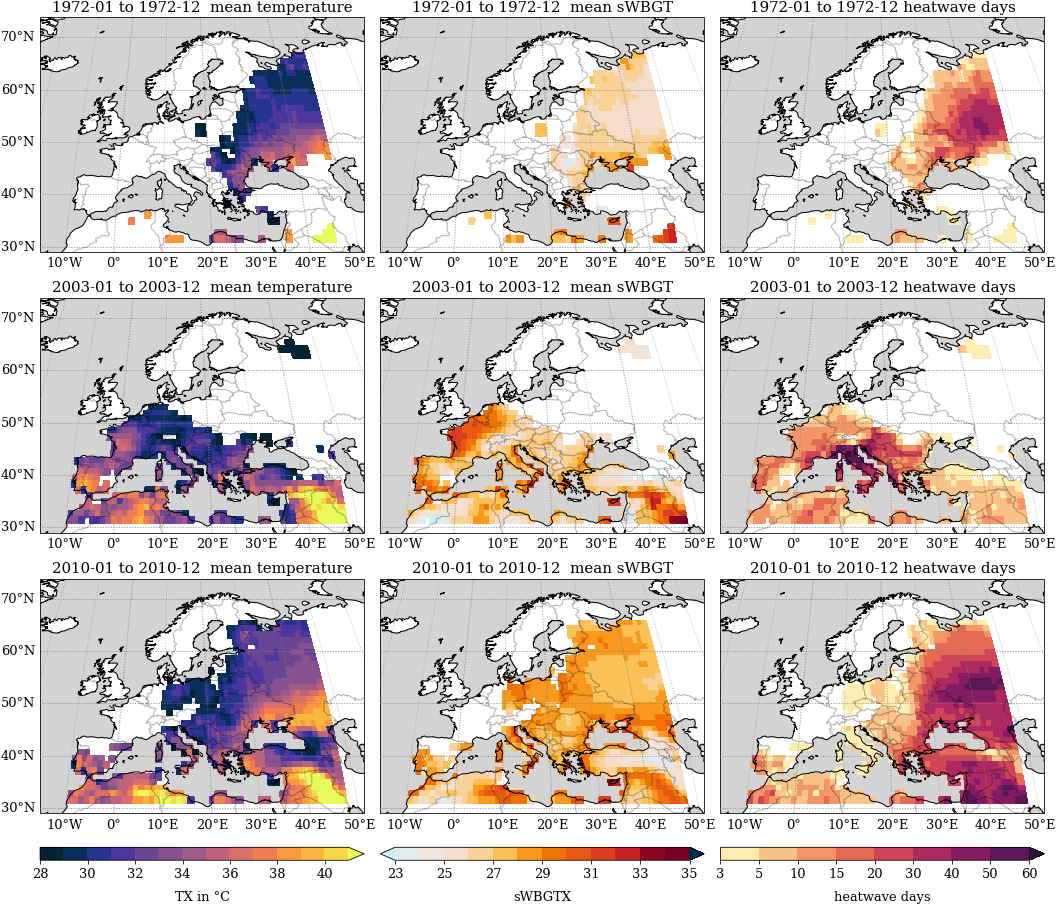

In [23]:
figure_title = "Strong heatwaves \nheatwave definition: \n {:.0f} days duration, {:.0f}°C daily max. temperature threshold, {:.0f}th percentile of temperature".format(duration, threshold, quantile*100)
fig = plt.figure(figsize = (18,16))
gs = gridspec.GridSpec(31, 3, hspace = 0.01, wspace = 0.05)
# fig.suptitle(figure_title, y=0.94)
# hex_list = ['#ffffff', '#f4f4f9', '#ffff3f', '#f9dcc4', '#fcbf49', '#f77f00', '#d62828', '#6a040f', '#003049']
# cmap_hwmid = plotfunc.get_continuous_cmap(hex_list, float_list=[0, 0.1, 0.25,0.4, 0.5, 0.75, 0.85, 0.99, 1])
hex_list = ['#caf0f8', '#eaeaea', '#f9dcc4', '#fcbf49', '#f77f00', '#d62828', '#6a040f', '#720026', '#003049']
cmap_hwmid = plotfunc.get_continuous_cmap(hex_list, float_list=[0, 0.1, 0.25,0.4, 0.5, 0.75, 0.85, 0.99, 1])
slices = [slice("1972-01","1972-12"), slice("2003-01","2003-12"), slice("2010-01","2010-12")]

idx = 0
for timeslice in slices:

    # plot temperature
        ax0 = fig.add_subplot(gs[idx*10:(idx+1)*10, 0],\
            projection=projection)
        ax0.set_extent([-17,51,29,73])
        plot_data = data.t2m.where(data.heatwave_mask_ydrunpctl_95).sel(time = timeslice).mean('time')
        plot_data = plot_data.where(data.mask_land)
        pm0, ct0 = plotfunc.area_plot(data= plot_data, ax = ax0, \
                    levels = np.arange(28,42,1), \
                    cmap = 'cmo.thermal',
                    colorbar_kwargs = dict(extend = 'max', add_colorbar = False))
        ax0.set_title("{} to {}  mean temperature".format(timeslice.start, timeslice.stop))

    # plot sWBGT
        ax1 = fig.add_subplot(gs[idx*10:(idx+1)*10, 1],\
            projection=projection)
        ax1.set_extent([-17,51,29,73])
        plot_data = data.swbgt.where(data.heatwave_mask_ydrunpctl_95).sel(time = timeslice).mean('time')
        plot_data = plot_data.where(data.mask_land)
        pm1, ct1 = plotfunc.area_plot(data= plot_data, ax = ax1, \
                    levels = np.arange(23,36,1), \
                    cmap = plotfunc.thermal_low_extend,
                    colorbar_kwargs = dict(extend = 'both', add_colorbar = False),
                    gridline_kwargs = dict(left_labels = False))
        ax1.set_title("{} to {}  mean sWBGT".format(timeslice.start, timeslice.stop))

    # plot heatwave days
        ax2 = fig.add_subplot(gs[idx*10:(idx+1)*10, 2],\
            projection=projection)
        ax2.set_extent([-17,51,29,73])
        plot_data = data.heatwave_mask_ydrunpctl_95.sel(time = timeslice).sum("time")
        plot_data = plot_data.where(data.mask_land).where(plot_data >= duration)
        pm2, ct2 = plotfunc.area_plot(data= plot_data, ax = ax2, \
            levels = [3,5,10,15,20,30,40,50,60], \
            cmap = 'cmo.matter',
            colorbar_kwargs = dict(extend = 'max', add_colorbar = False),
                    gridline_kwargs = dict(left_labels = False))
        ax2.set_title("{} to {} heatwave days".format(timeslice.start, timeslice.stop))

        idx += 1

def create_cbar_axes(ax):
    pos = ax.get_position()
    return fig.add_axes([pos.x0 , pos.y0 - pos.height *0.2, pos.width, pos.width  *0.045], frameon = False, xticks = [], yticks = [])
ax0 = create_cbar_axes(ax0)
ax1 = create_cbar_axes(ax1)
ax2 = create_cbar_axes(ax2)
# ax1 = fig.add_subplot(gs_outer[1,-1], frameon = False, xticks = [], yticks = [])
# ax2 = fig.add_subplot(gs_outer[2,-1], frameon = False, xticks = [], yticks = [])

plotfunc.add_cbar(fig,ax0,mapple_object=pm0, percentage = "120%", divide = False, extend = 'max', orientation = 'horizontal', label = 'TX in °C')
plotfunc.add_cbar(fig,ax1,mapple_object=pm1, percentage = "120%", divide = False, extend = 'both', orientation = 'horizontal', label = 'sWBGTX')
plotfunc.add_cbar(fig,ax2,mapple_object=pm2, percentage = "120%", divide = False, extend = 'max', orientation = 'horizontal', label = "heatwave days")


# #         dived = False
# ax0 = fig.add_subplot(gs[-1,0], frameon = False, xticks = [], yticks = [])
# ax1 = fig.add_subplot(gs[-1,1], frameon = False, xticks = [], yticks = [])
# ax2 = fig.add_subplot(gs[-1,2], frameon = False, xticks = [], yticks = [])

# plotfunc.add_cbar(fig,ax0,mapple_object=pm0, percentage = "100%", divide = False, extend = 'max', orientation = 'horizontal', label = 'Temperature in °C')
# plotfunc.add_cbar(fig,ax1,mapple_object=pm1, percentage = "100%", divide = False, extend = 'both', orientation = 'horizontal', label = 'sWBGT')
# plotfunc.add_cbar(fig,ax2,mapple_object=pm2, percentage = "100%", divide = False, extend = 'max', orientation = 'horizontal', label = "heatwave days")

fig.savefig(areafolder + 'example_heatwaves_ydrunpctl_95')

**Plot 30 year periods**

/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


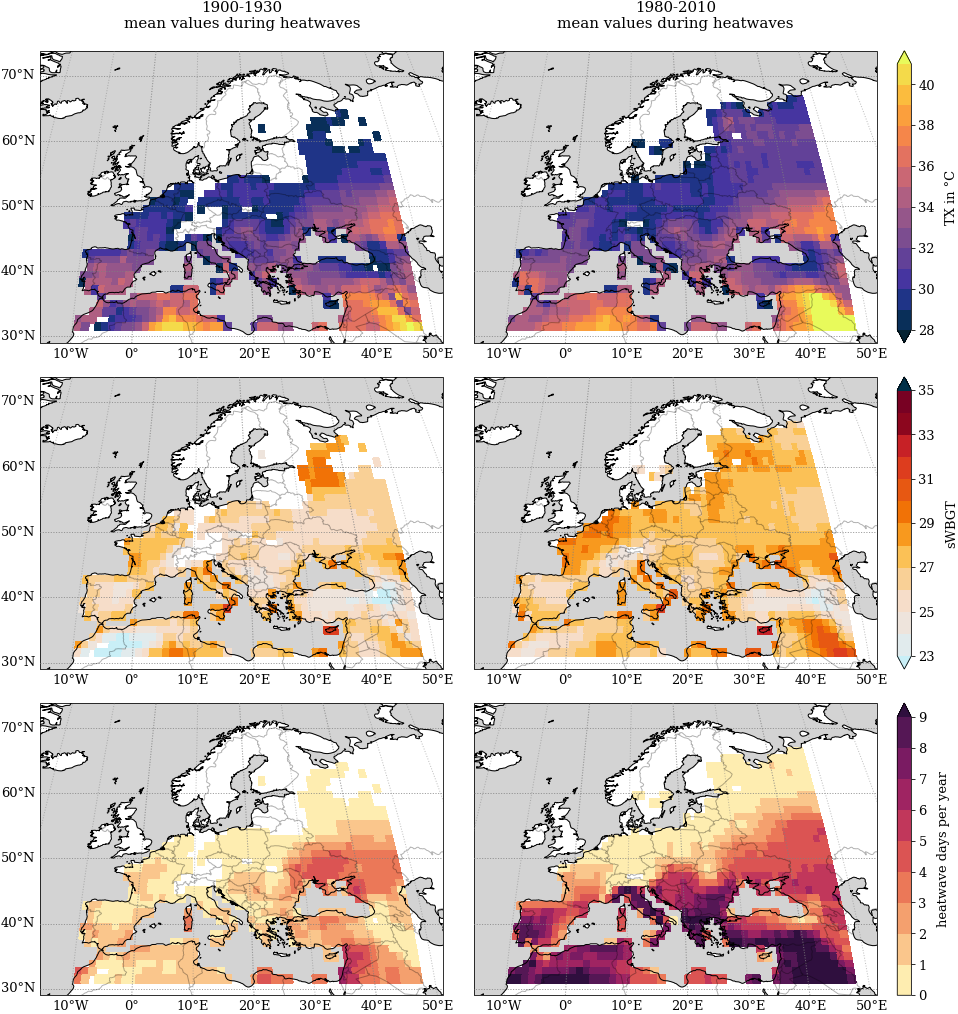

In [27]:
figure_title = "Heatwave definition: \n {:.0f} days duration, {:.0f}°C daily max. temperature threshold, {:.0f}th percentile of temperature".format(duration, threshold, quantile*100)
fig = plt.figure(figsize = (15,18))

gs = gridspec.GridSpec(nrows = 3, ncols = 2, wspace = 0.075, hspace = 0.0)
# gs_outer = gridspec.GridSpec(nrows = 3, ncols = 2, hspace = 0.3)

# fig.suptitle(figure_title, y=0.94)


timeslice_first = slice("1900","1930")
timeslice_last = slice("1980","2010")
duration = 3
idx = 0

ax0 = fig.add_subplot(gs[:,0])
ax0.axis('off')
ax0.set_title('1900-1930\nmean values during heatwaves', fontsize = 15)

ax0 = fig.add_subplot(gs[:,1])
ax0.axis('off')
ax0.set_title('1980-2010\nmean values during heatwaves', fontsize = 15)

# ax0 = fig.add_subplot(gs_outer[:,2])
# ax0.axis('off')
# ax0.set_title('Change', fontsize = 15)
title = ['a)','c)','e)','b)','d)','f)']
idx = 0
idx_title = 0
left_labels = True
for timeslice in [timeslice_first, timeslice_last]:
    
        
        total_years = (int(timeslice.start) - int(timeslice.stop))

# plot temperature
        ax0 = fig.add_subplot(gs[0, idx], projection=projection)
        plot_data = data.t2m.where(data.heatwave_mask_ydrunpctl_95).sel(time = timeslice).mean('time')
        plot_data = plot_data.where(data.mask_land)
        pm0, ct0 = plotfunc.area_plot(data= plot_data, ax = ax0,             levels = np.arange(28,42,1),             cmap = 'cmo.thermal',
            colorbar_kwargs = dict(add_colorbar = False, extend = 'both'),
                    gridline_kwargs = dict(left_labels = left_labels))
#         ax.set_title("mean temperature during heatwaves")
#         ax.set_title(title[idx_title])
# plot sWBGT
        ax1 = fig.add_subplot(gs[1,idx], projection=projection)
        plot_data = data.swbgt.where(data.heatwave_mask_ydrunpctl_95).sel(time = timeslice).mean('time')
        plot_data = plot_data.where(data.mask_land)
        pm1, ct1 = plotfunc.area_plot(data= plot_data, ax = ax1,             levels = np.arange(23,36,1),             cmap = plotfunc.thermal_low_extend,
            colorbar_kwargs = dict(add_colorbar = False, extend = 'both'),
                    gridline_kwargs = dict(left_labels = left_labels))
#         ax.set_title("mean sWBGT during heatwaves")
#         ax.set_title(title[idx_title + 1])        

# plot heatwave days
        ax2 = fig.add_subplot(gs[2,idx], projection=projection)
        plot_data = data.heatwave_mask_ydrunpctl_95.sel(time = timeslice).sum("time") / 31
        plot_data = plot_data.where(data.mask_land).where(plot_data != 0)
        pm2, ct2 = plotfunc.area_plot(data= plot_data, ax = ax2,
            levels = np.arange(0,10,1), 
            cmap = 'cmo.matter',
            colorbar_kwargs = dict(add_colorbar = False, extend = 'max'),
                    gridline_kwargs = dict(left_labels = left_labels))
#         ax.set_title("mean heatwave days per year")
#         ax.set_title(title[idx_title + 2])
        idx += 1
        left_labels = False


 #         dived = False
def create_cbar_axes(ax):
    pos = ax.get_position()
    return fig.add_axes([pos.x0 + pos.width *1.05, pos.y0, pos.width *0.035, pos.height], frameon = False, xticks = [], yticks = [])
ax0 = create_cbar_axes(ax0)
ax1 = create_cbar_axes(ax1)
ax2 = create_cbar_axes(ax2)
# ax1 = fig.add_subplot(gs_outer[1,-1], frameon = False, xticks = [], yticks = [])
# ax2 = fig.add_subplot(gs_outer[2,-1], frameon = False, xticks = [], yticks = [])

plotfunc.add_cbar(fig,ax0,mapple_object=pm0, percentage = "120%", divide = False, extend = 'both', orientation = 'vertical', label = 'TX in °C')
plotfunc.add_cbar(fig,ax1,mapple_object=pm1, percentage = "120%", divide = False, extend = 'both', orientation = 'vertical', label = 'sWBGT')
plotfunc.add_cbar(fig,ax2,mapple_object=pm2, percentage = "120%", divide = False, extend = 'max', orientation = 'vertical', label = "heatwave days per year")

fig.savefig(areafolder + "30year_period_heatwave_ydrunpctl_95")

**Plot the changes and trends**

/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


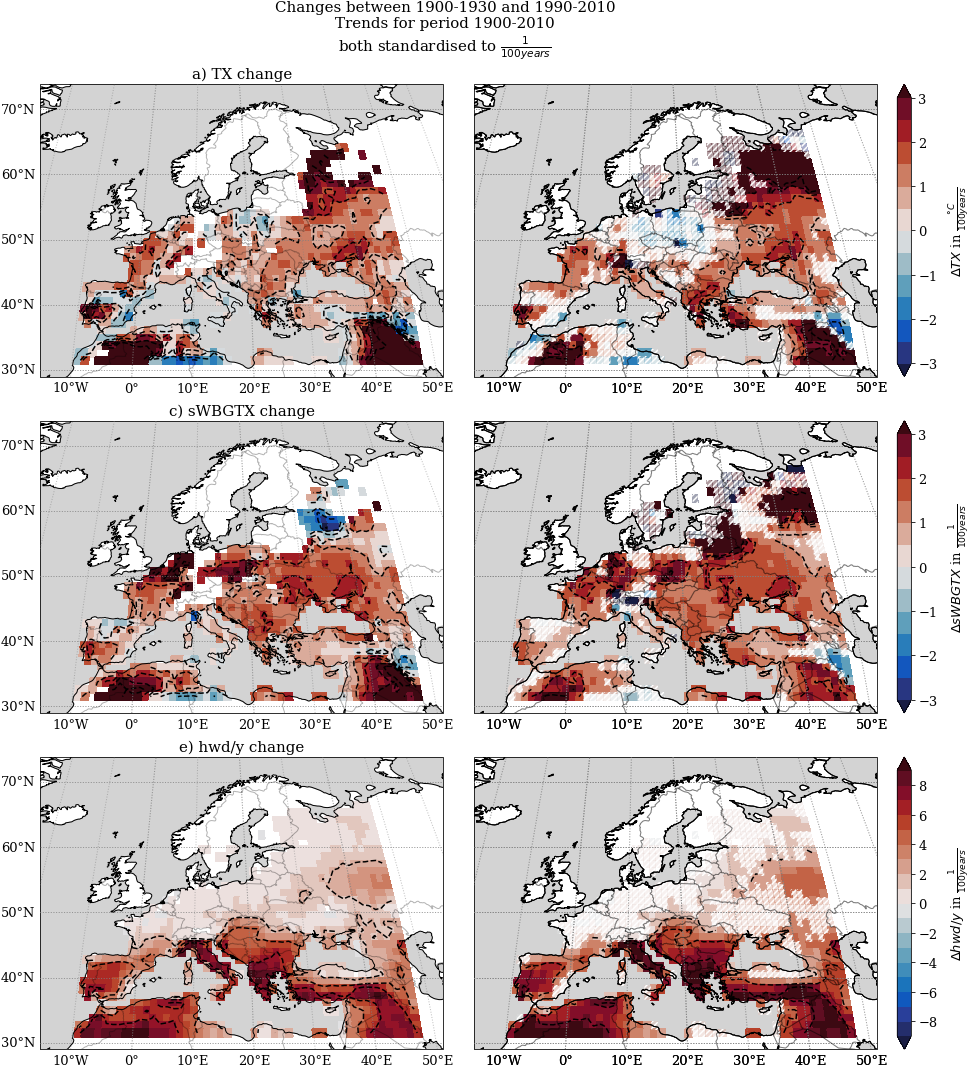

In [26]:
figure_title = 'Changes between 1900-1930 and 1990-2010\nTrends for period 1900-2010\nboth standardised to ' + r'$\frac{1}{100 years}$'
fig = plt.figure(figsize = (15,18))

gs = gridspec.GridSpec(nrows = 3, ncols = 2, wspace = 0.075, hspace = 0.1)
fig.suptitle(figure_title, y=0.94)

cmap_trend = 'cmo.balance'

timeslice_first = slice("1900","1930")
timeslice_last = slice("1980","2010")
duration = 3
idx = 0


# ax0 = fig.add_subplot(gs_outer[:,2])
# ax0.axis('off')
# ax0.set_title('Change', fontsize = 15)

# ====== Plot ======

select_data = lambda variable, timeslice : data[variable].where(data.heatwave_mask_ydrunpctl_95).sel(time = timeslice)
dim = 'time'
# ----- Temperature -----------
# Change
variable = "t2m"
plot_data = select_data(variable, timeslice_last).mean('time') - select_data(variable, timeslice_first).mean('time')
plot_data = plot_data.where(data.mask_land) *100/80

ax = fig.add_subplot(gs[0, 0], projection=projection)
pm, ct = plotfunc.area_plot(data= plot_data, ax = ax,
    levels = np.arange(0,3.1,0.5),
    cmap = cmap_trend,
    contour = True, contour_levels = np.arange(-5,5,1), contour_kwargs = dict(colors= 'k', linestyles = '--', linewidths = 1.5), 
    colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'))
ax.set_title('a) TX change')

# Trend
sel_data = data.t2m.where(data.mask_land).where(data.heatwave_mask_ydrunpctl_95)
x = (sel_data[dim] - sel_data[dim][0]).astype(float)
linreg = trends.gufunc_linreg(x,sel_data, dim= dim)

ax0 = fig.add_subplot(gs[0,1],\
        projection=projection)
ax0.set_title("b) TX trend")

plot_data = linreg["slope"]* (x[-1]-x[0]) *100/110
pm0, ct = plotfunc.area_plot(data= plot_data.where(linreg["p_value"] < 0.05),
                ax = ax0,
                levels = np.arange(0,3.1,0.5), cmap = cmap_trend,
                contour = True, contour_levels = np.arange(-5,5,1), contour_kwargs = dict(colors= 'k', linestyles = '--', linewidths = 1.5), 
                colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'),
                gridline_kwargs = dict(left_labels = left_labels))

pm, ct = plotfunc.area_plot(data= plot_data.where(linreg["p_value"] >= 0.05),
                ax = ax0, pcolormesh=False, pcolor= True,
                levels = np.arange(0,3.1,0.5), cmap = cmap_trend,
                colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'),
                gridline_kwargs = dict(left_labels = left_labels),
                pcolormesh_kwargs=dict(hatch = "////", alpha = 0.4))


# ----- sWBGT -----------
# Change
variable = "swbgt"
plot_data = select_data(variable, timeslice_last).mean('time') - select_data(variable, timeslice_first).mean('time')
plot_data = plot_data.where(data.mask_land) *100/80

ax = fig.add_subplot(gs[1, 0], projection=projection)
pm, ct = plotfunc.area_plot(data= plot_data, ax = ax,
    levels = np.arange(0,3.1,0.5),
    cmap = cmap_trend,
    contour = True, contour_levels = np.arange(-5,5,1), contour_kwargs = dict(colors= 'k', linestyles = '--', linewidths = 1.5), 
    colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'))
ax.set_title("c) sWBGTX change")

# Trend
sel_data = data.swbgt.where(data.mask_land).where(data.heatwave_mask_ydrunpctl_95)
x = (sel_data[dim] - sel_data[dim][0]).astype(float)
linreg = trends.gufunc_linreg(x,sel_data, dim= dim)

ax1 = fig.add_subplot(gs[1,1],\
        projection=projection)
ax1.set_title("d) sWBGTX trend")

plot_data = linreg["slope"]* (x[-1]-x[0]) *100/110
pm1, ct = plotfunc.area_plot(data= plot_data.where(linreg["p_value"] < 0.05),
                ax = ax1,
                levels = np.arange(0,3.1,0.5), cmap = cmap_trend,
                contour = True, contour_levels = np.arange(-5,5,1), contour_kwargs = dict(colors= 'k', linestyles = '--', linewidths = 1.5), 
                colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'),
                gridline_kwargs = dict(left_labels = left_labels))

pm, ct = plotfunc.area_plot(data= plot_data.where(linreg["p_value"] >= 0.05),
                ax = ax1, pcolormesh=False, pcolor= True,
                levels = np.arange(0,3.1,0.5), cmap = cmap_trend,
                colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'),
                gridline_kwargs = dict(left_labels = left_labels),
                pcolormesh_kwargs=dict(hatch = "////", alpha = 0.4))



# ----- heatwave days -----------
# Change
ax = fig.add_subplot(gs[2, 0], projection=projection)

variable = "heatwave_mask_ydrunpctl_95"
plot_data = select_data(variable, timeslice_last).sum('time')/31 - select_data(variable, timeslice_first).sum('time')/31
plot_data = plot_data.where(data.mask_land).where(plot_data != 0) *100/80


pm, ct = plotfunc.area_plot(data= plot_data, ax = ax,
    levels = np.arange(0,12,1),
    cmap = cmap_trend,
    contour = True, contour_levels = np.arange(-10,10,3), contour_kwargs = dict(colors= 'k', linestyles = '--', linewidths = 1.5), 
    colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'))
ax.set_title("e) hwd/y change")

# Trend
ax2 = fig.add_subplot(gs[2,1],\
        projection=projection)

sel_data= data.heatwave_mask_ydrunpctl_95.groupby('time.year').sum("time").where(data.mask_land)
x = (sel_data["year"] - sel_data["year"][0]).astype(float)
linreg = trends.gufunc_linreg(x,sel_data, dim= "year")
plot_data = linreg["slope"]* (x[-1]-x[0]) *100/110
ax2.set_title("f) hwd/y trend")

plot_data = plot_data.where(plot_data != 0)
pm2, ct = plotfunc.area_plot(data= plot_data.where(linreg["p_value"] < 0.05),
                ax = ax2,
                levels = np.arange(0,10,1), cmap = cmap_trend,
                colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'),
                contour = True, contour_levels = np.arange(-10,10,3), contour_kwargs = dict(colors= 'k', linestyles = '--', linewidths = 1.5), 
                gridline_kwargs = dict(left_labels = left_labels))

pm, ct = plotfunc.area_plot(data= plot_data.where(linreg["p_value"] >= 0.05),
                ax = ax2, pcolormesh=False, pcolor= True,
                levels = np.arange(0,10,1), cmap = cmap_trend,
                colorbar_kwargs = dict(add_colorbar = False, divergent = True, extend = 'both'),
                gridline_kwargs = dict(left_labels = left_labels),
                pcolormesh_kwargs=dict(hatch = "////", alpha = 0.4))

#         dived = False
def create_cbar_axes(ax):
    pos = ax.get_position()
    return fig.add_axes([pos.x0 + pos.width *1.05, pos.y0, pos.width *0.035, pos.height], frameon = False, xticks = [], yticks = [])
ax0 = create_cbar_axes(ax0)
ax1 = create_cbar_axes(ax1)
ax2 = create_cbar_axes(ax2)

# ax1 = fig.add_subplot(gs_outer[1,-1], frameon = False, xticks = [], yticks = [])
# ax2 = fig.add_subplot(gs_outer[2,-1], frameon = False, xticks = [], yticks = [])

plotfunc.add_cbar(fig,ax0,mapple_object=pm0, percentage = "120%", divide = False, extend = 'both', orientation = 'vertical', label = r'${\Delta} {TX}$ in $\frac{°C}{100 years}$')
plotfunc.add_cbar(fig,ax1,mapple_object=pm1, percentage = "120%", divide = False, extend = 'both', orientation = 'vertical', label = r'${\Delta} {sWBGTX}$ in $\frac{1}{100 years}$')
plotfunc.add_cbar(fig,ax2,mapple_object=pm2, percentage = "120%", divide = False, extend = 'both', orientation = 'vertical', label = r'${\Delta} {hwd/y}$ in $\frac{1}{100 years}$')

fig.savefig(areafolder + "area_changes_trends_ydrunpctl_95")

**Plot 98th percentile and change**

/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN sl

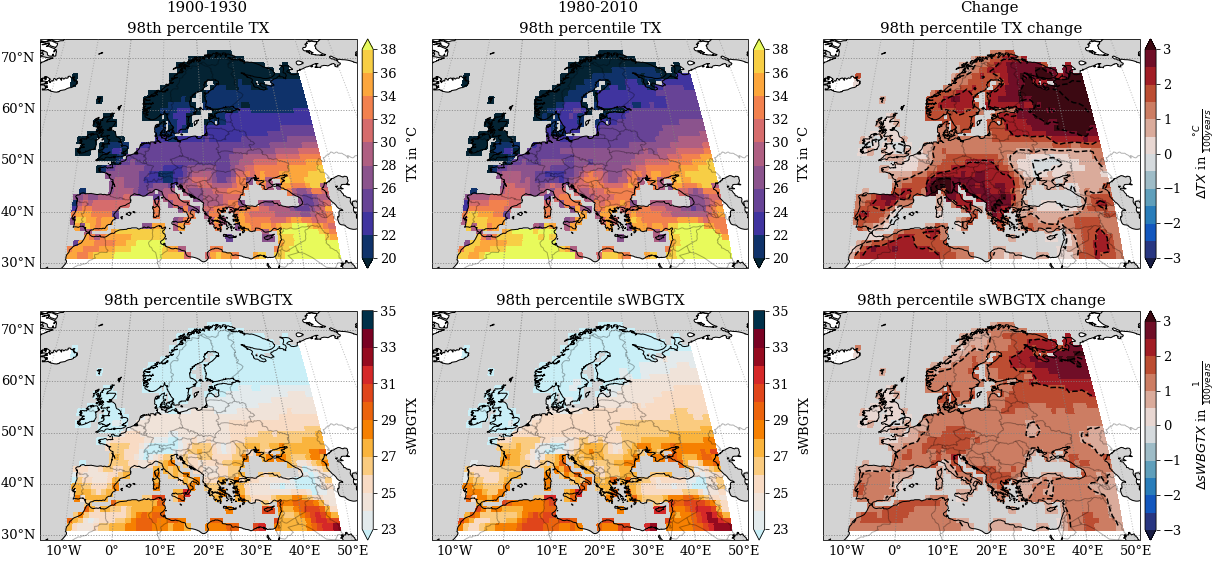

In [6]:
# figure_title = 'heatwave definition: \n {:.0f} days duration, {:.0f}°C daily max. temperature threshold, {:.0f}th percentile of temperature'.format(duration, threshold, quantile*100)
fig = plt.figure(figsize = (20,10))
# fig.suptitle(figure_title, y=0.94)

gs_outer = gridspec.GridSpec(2, 3, wspace = 0.175, hspace = 0.3)

timeslice_first = slice("1900","1930")
timeslice_last = slice("1980","2010")
duration = 3
idx = 0

ax0 = fig.add_subplot(gs_outer[:,0])
ax0.axis('off')
ax0.set_title('1900-1930')

ax0 = fig.add_subplot(gs_outer[:,1])
ax0.axis('off')
ax0.set_title('1980-2010')

ax0 = fig.add_subplot(gs_outer[:,2])
ax0.axis('off')
ax0.set_title('Change')

idx = 0
left_labels = True
for timeslice in [timeslice_first, timeslice_last]:
    
        total_years = (int(timeslice.start) - int(timeslice.stop))
        gs = gs_outer[:,idx].subgridspec(2, 1, hspace= 0., wspace= 0.)
# plot temperature
        ax = fig.add_subplot(gs[0, :], projection=projection)
        plot_data = (data.t2m.sel(time = timeslice).where(data.mask_land)).quantile(0.98, dim = 'time')
        pm, ct = plotfunc.area_plot(data= plot_data, ax = ax,             
                        levels = np.arange(20,40,2),             
                        cmap = 'cmo.thermal',
                        gridline_kwargs = dict(left_labels = left_labels, bottom_labels = False),
                        colorbar_kwargs = dict(label = "TX in °C"))
        ax.set_title("98th percentile TX")
        
# plot sWBGT
        ax = fig.add_subplot(gs[1,:], projection=projection)
        plot_data = (data.swbgt.sel(time = timeslice).where(data.mask_land)).quantile(0.98, dim = 'time')
        pm, ct = plotfunc.area_plot(data= plot_data, ax = ax,             
                        levels = np.arange(23,36,1),             
                        cmap = plotfunc.thermal_low_extend,
                        gridline_kwargs = dict(left_labels = left_labels),
                        colorbar_kwargs = dict(label = "sWBGTX"))
        ax.set_title("98th percentile sWBGTX")
        
        left_labels = False

        idx += 1

        
# plot difference

select_data = lambda variable, timeslice : data[variable].sel(time = timeslice).where(data.mask_land)

gs = gs_outer[:,idx].subgridspec(2, 1, hspace= 0., wspace= 0.)
# plot temperature
variable = "t2m"
plot_data = (select_data(variable, timeslice_last)).quantile(0.98, dim = 'time') - (select_data(variable, timeslice_first)).quantile(0.98, dim = 'time')
plot_data = plot_data * (100/80)

ax = fig.add_subplot(gs[0, :], projection=projection)
pm, ct = plotfunc.area_plot(data= plot_data, ax = ax,
    levels = np.arange(0,3.1,0.5),
    cmap = 'cmo.balance',
    contour = True, contour_levels = np.arange(-5,5,1), contour_kwargs = dict(colors= 'k', linestyles = '--', linewidths = 1.5), 
    gridline_kwargs = dict(left_labels = left_labels, bottom_labels = False),
    colorbar_kwargs = dict(divergent = True, extend = 'both', label = r'${\Delta} {TX}$ in $\frac{°C}{100 years}$'))
ax.set_title("98th percentile TX change")

# plot sWBGT
variable = "swbgt"
plot_data = select_data(variable, timeslice_last).quantile(0.98, dim = 'time') - select_data(variable, timeslice_first).quantile(0.98, dim = 'time')
plot_data = plot_data * (100/80)

ax = fig.add_subplot(gs[1, :], projection=projection)
pm, ct = plotfunc.area_plot(data= plot_data, ax = ax,
    levels = np.arange(0,3.1,0.5),
    cmap = 'cmo.balance',
    contour = True, contour_levels = np.arange(-5,5,1), contour_kwargs = dict(colors= 'k', linestyles = '--', linewidths = 1.5), 
    gridline_kwargs = dict(left_labels = left_labels),
    colorbar_kwargs = dict(divergent = True, extend = 'both', label = r'${\Delta} {sWBGTX}$ in $\frac{1}{100 years}$'))
ax.set_title("98th percentile sWBGTX change")

fig.savefig(areafolder + "30year_period_98thpercentile_ydrunpctl_95")

**Plot mean and change**

/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


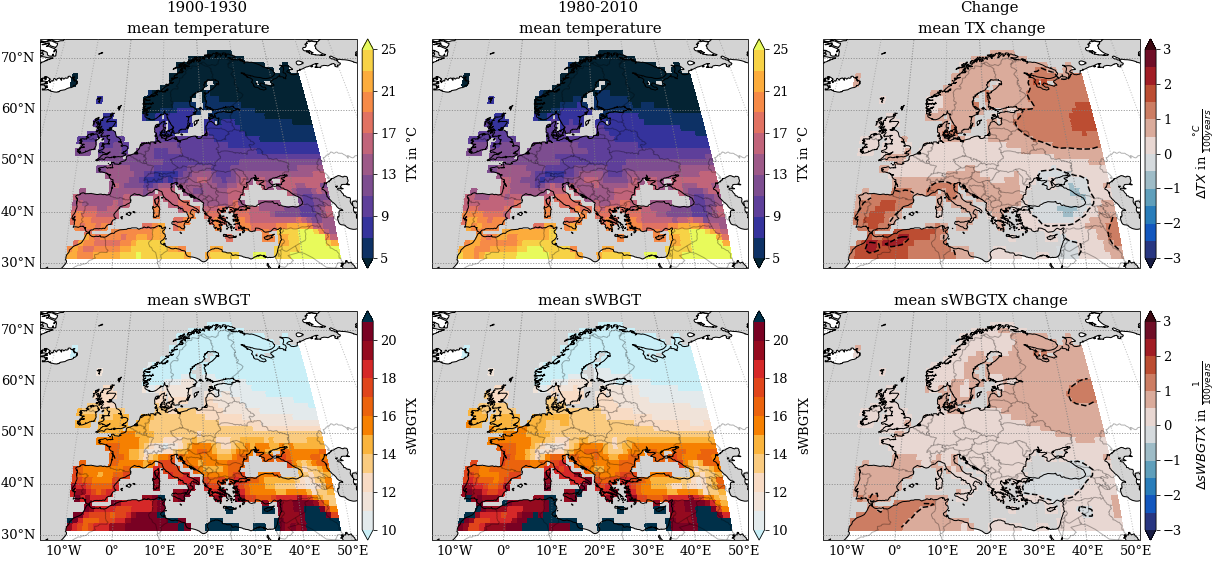

In [7]:
# figure_title = 'heatwave definition: \n {:.0f} days duration, {:.0f}°C daily max. temperature threshold, {:.0f}th percentile of temperature'.format(duration, threshold, quantile*100)
fig = plt.figure(figsize = (20,10))
# fig.suptitle(figure_title, y=0.94)

gs_outer = gridspec.GridSpec(2, 3, wspace = 0.175, hspace = 0.3)

timeslice_first = slice("1900","1930")
timeslice_last = slice("1980","2010")
duration = 3
idx = 0

ax0 = fig.add_subplot(gs_outer[:,0])
ax0.axis('off')
ax0.set_title('1900-1930')

ax0 = fig.add_subplot(gs_outer[:,1])
ax0.axis('off')
ax0.set_title('1980-2010')

ax0 = fig.add_subplot(gs_outer[:,2])
ax0.axis('off')
ax0.set_title('Change')

idx = 0
left_labels = True
for timeslice in [timeslice_first, timeslice_last]:
    
        total_years = (int(timeslice.start) - int(timeslice.stop))
        gs = gs_outer[:,idx].subgridspec(2, 1, hspace= 0., wspace= 0.)
# plot temperature
        ax = fig.add_subplot(gs[0, :], projection=projection)
        plot_data = (data.t2m.sel(time = timeslice).where(data.mask_land)).mean('time')
        pm, ct = plotfunc.area_plot(data= plot_data, ax = ax,             
                        levels = np.arange(5,26,2),             
                        cmap = 'cmo.thermal',
                        gridline_kwargs = dict(left_labels = left_labels, bottom_labels = False),
                        colorbar_kwargs = dict(label = "TX in °C"))
        ax.set_title("mean temperature")
        
# plot sWBGT
        ax = fig.add_subplot(gs[1,:], projection=projection)
        plot_data = (data.swbgt.sel(time = timeslice).where(data.mask_land)).mean('time')
        pm, ct = plotfunc.area_plot(data= plot_data, ax = ax,             
                        levels = np.arange(10,22,1),             
                        cmap = plotfunc.thermal_low_extend,
                            gridline_kwargs = dict(left_labels = left_labels),
                        colorbar_kwargs = dict(label = "sWBGTX"))
        ax.set_title("mean sWBGT")
        
        
        left_labels = False
        idx += 1

        
# plot difference

select_data = lambda variable, timeslice : data[variable].sel(time = timeslice).where(data.mask_land)

gs = gs_outer[:,idx].subgridspec(2, 1, hspace= 0., wspace= 0.)
# plot temperature
variable = "t2m"
plot_data = (select_data(variable, timeslice_last)).mean('time') - (select_data(variable, timeslice_first)).mean('time')
plot_data = plot_data * (100/80)

ax = fig.add_subplot(gs[0, :], projection=projection)
pm, ct = plotfunc.area_plot(data= plot_data, ax = ax,
    levels = np.arange(0,3.1,0.5),
    contour = True, contour_levels = np.arange(-5,5,1), contour_kwargs = dict(colors= 'k', linestyles = '--', linewidths = 1.5), 
    cmap = 'cmo.balance',
    gridline_kwargs = dict(left_labels = left_labels, bottom_labels = False),
    colorbar_kwargs = dict(divergent = True, extend = 'both',label = r'${\Delta} {TX}$ in $\frac{°C}{100 years}$'))
ax.set_title("mean TX change")

# plot sWBGT
variable = "swbgt"
plot_data = select_data(variable, timeslice_last).mean('time') - select_data(variable, timeslice_first).mean('time')
plot_data = plot_data * (100/80)

ax = fig.add_subplot(gs[1, :], projection=projection)
pm, ct = plotfunc.area_plot(data= plot_data, ax = ax,
    levels = np.arange(0,3.1,0.5),
    contour = True, contour_levels = np.arange(-5,5,1), contour_kwargs = dict(colors= 'k', linestyles = '--', linewidths = 1.5), 
    cmap = 'cmo.balance',
    gridline_kwargs = dict(left_labels = left_labels),
    colorbar_kwargs = dict(divergent = True, extend = 'both', label = r'${\Delta} {sWBGTX}$ in $\frac{1}{100 years}$'))
ax.set_title("mean sWBGTX change")

fig.savefig(areafolder + "30year_period_mean_ydrunpctl_95")

**REST**

In [82]:
def plot_30y_area(data = None, fig = None, mask_res = None, years = 31, cmap= "cmo.thermal", save_name = False, projection = ccrs.PlateCarree()):
    gs = gridspec.GridSpec(3, 1)
    
    # plot temperature
    ax = fig.add_subplot(gs[0,0],\
            projection=projection)
    ax.set_extent([-17,51,29,73])
    plot_data = data.t2m.where(mask_res, other = np.nan).groupby("time.year").max("time").mean('year')
    plot_data = plot_data.where(mc.mask_land(plot_data))
    pm, ct = plotfunc.area_plot(data= plot_data, ax = ax, \
        levels = np.arange(28, 42, 1), \
        contour_levels= np.arange(25,40,2), cmap = 'cmo.thermal',
#         landcolor = [0.4,0.4,0.4]
                               )
    
#     add_cbar(fig = fig, ax=ax, pm = pm, label = "Temperature in °C")
    # cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
    # fig.add_axes(cax)
    # fig.colorbar(im, cax=cax, orientation="horizontal")

    ax.set_title("a) mean yearly maximum temperature during heat wave")
    #
    ax1 = fig.add_subplot(gs[1,0],\
            projection=projection)
    ax.set_extent([-17,51,29,73])
    plot_data = data.swbgt.where(mask_res, other = np.nan).groupby("time.year").max("time", skipna= True).mean('year', skipna= True)
    plot_data = plot_data.where(mc.mask_land(plot_data))
    pm, ct = plotfunc.area_plot(data= plot_data, ax = ax1, \
        levels = np.arange(22, 35, 1), \
        contour_levels= np.arange(15,35,2), \
        cmap = plotfunc.thermal_low_extend,
#         landcolor = [0.4,0.4,0.4]
                               )

#     cbar = add_cbar(fig = fig, ax=ax1, pm = pm, label = "sWBGT")
    ax1.set_title("b) mean yearly maximum sWBGT during heat wave")

    ax2 = fig.add_subplot(gs[2,0],\
            projection=projection)
    ax.set_extent([-17,51,29,73])
    plot_data = mask_res.groupby('time.year').sum("time").mean('year')
    plot_data = plot_data.where(plot_data != 0)
    pm, ct = plotfunc.area_plot(data= plot_data, ax = ax2, \
        levels =  np.arange(0, 10, 0.5), \
        contour_levels= np.arange(1,10,2), \
        cmap = "cmo.matter")
    
    ax2.set_title("mean yearly heatwave days")
#     cbar = add_cbar(fig = fig, ax = ax2, pm = pm, label = "log(days)")

    year_start = data.time[0].dt.strftime("%Y").values
    year_end = year = data.time[-1].dt.strftime("%Y").values

    # ax3 = fig.add_subplot(gs[0,2])
    # x = data_max.t2m.where(mask_res).sel(time = timeslice)
    # y = data_max.swbgt.where(mask_res).sel(time = timeslice)
    # ax3.scatter(x,y, marker = '.')

    year = data.time[0].dt.strftime("%Y-%m-%d").values
    if save_name:
        fig.savefig(save_name + '.png')
        fig.savefig(save_name + '.pdf')
    return fig


**Definition based on the DWD**

2.03657603263855


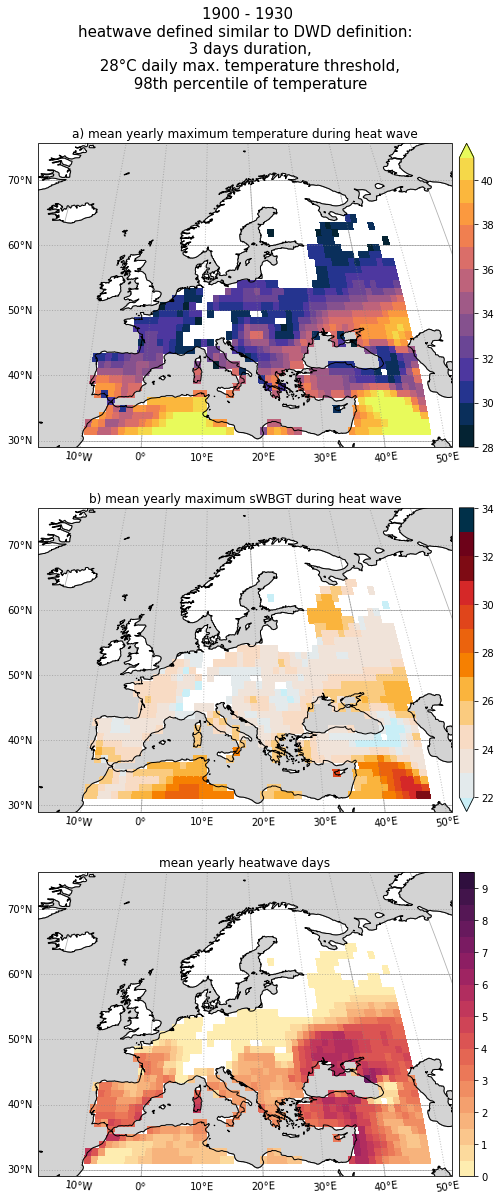

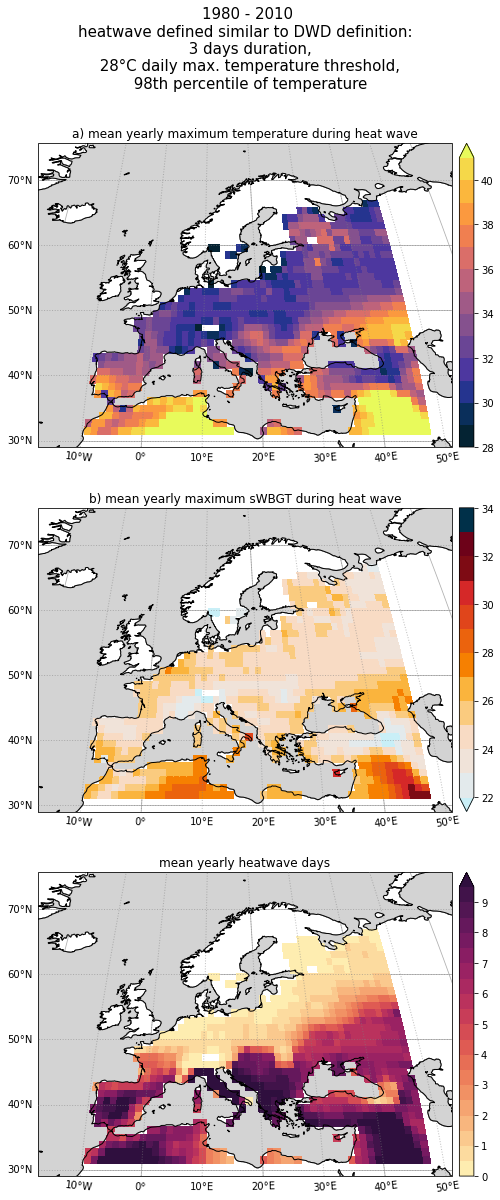

In [8]:
# NOTE: for the quantile mask, it has to be above the general 98th percentile!!

threshold = 28
duration = 3
quantile = 0.98

mask_lambda = lambda x : (x.t2m >= threshold) & x.t2m_mask_quantiles.sel(quantile = quantile)

st = time.time()
mask = hwi.calc_heatwave_index(mask_original= mask_lambda(data), duration = duration)
mask = mask.where(mc.mask_land(mask))
print(time.time() -st)



for timeslice in [slice("1900", "1930"), slice("1980", "2010")] :
    fig = plt.figure(figsize = (9,19))
    fig.suptitle(timeslice.start + " - " + timeslice.stop + "\nheatwave defined similar to DWD definition: \n {:.0f} days duration,\n {:.0f}°C daily max. temperature threshold,\n {:.0f}th percentile of temperature".format(duration, threshold, quantile*100),\
                fontsize= 15)
    fig = plot_30y_area(fig = fig, data = data.sel(time= timeslice), mask_res = mask.sel(time= timeslice),
                        save_name = areafolder + "europe_{}-{}_dwd".format(timeslice.start, timeslice.stop), projection=projection)

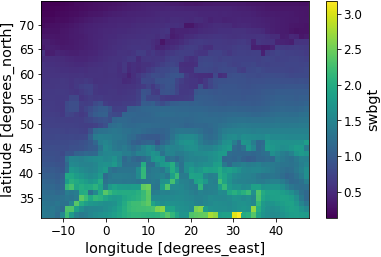

In [15]:
data_new = xr.open_dataset(datafolder + '/europe_daymax_1900-01-01_2010-12-31.nc')

data

In [13]:
midday = data_6h.time.dt.hour

<xarray.DataArray 'hour' (time: 40542)>
array([9, 9, 9, ..., 9, 9, 9])
Coordinates:
  * time     (time) datetime64[ns] 1900-01-01T09:00:00 ... 2010-12-31T09:00:00